# 2D Nuclear Segmentation with RetinaNet

In [1]:
import os
import errno

import numpy as np

import deepcell

Using TensorFlow backend.


In [2]:
# Download the data (saves to ~/.keras/datasets)
filename = 'HeLa_S3.npz'
(X_train, y_train), (X_test, y_test) = deepcell.datasets.hela_s3.load_data(filename)

print('X.shape: {}\ny.shape: {}'.format(X_train.shape, y_train.shape))

X.shape: (5760, 216, 256, 1)
y.shape: (5760, 216, 256, 1)


### Set up filepath constants

In [3]:
# the path to the data file is currently required for `train_model_()` functions

# NOTE: Change DATA_DIR if you are not using `deepcell.datasets`
DATA_DIR = os.path.expanduser(os.path.join('~', '.keras', 'datasets'))

DATA_FILE = os.path.join(DATA_DIR, filename)

# confirm the data file is available
assert os.path.isfile(DATA_FILE)

In [4]:
# Set up other required filepaths

# If the data file is in a subdirectory, mirror it in MODEL_DIR and LOG_DIR
PREFIX = os.path.relpath(os.path.dirname(DATA_FILE), DATA_DIR)

ROOT_DIR = '/data'  # TODO: Change this! Usually a mounted volume
MODEL_DIR = os.path.abspath(os.path.join(ROOT_DIR, 'models', PREFIX))
LOG_DIR = os.path.abspath(os.path.join(ROOT_DIR, 'logs', PREFIX))

# create directories if they do not exist
for d in (MODEL_DIR, LOG_DIR):
    try:
        os.makedirs(d)
    except OSError as exc:  # Guard against race condition
        if exc.errno != errno.EEXIST:
            raise

### Set up training parameters

In [5]:
from tensorflow.keras.optimizers import SGD, Adam
from deepcell.utils.train_utils import rate_scheduler

model_name = 'retinanet_model'
backbone = 'vgg19'  # vgg16, vgg19, resnet50, densenet121, densenet169, densenet201

n_epoch = 20  # Number of training epochs
test_size = .20  # % of data saved as test
lr = 1e-5

optimizer = Adam(lr=lr, clipnorm=0.001)

lr_sched = rate_scheduler(lr=lr, decay=0.99)

batch_size = 1

num_classes = 1  # "object" is the only class

## Create the RetinaNet Model

In [6]:
from deepcell import model_zoo

# training model is `retinanet` while prediction model is `retinanet_bbox`
model = model_zoo.RetinaNet(
    backbone=backbone,  
    input_shape=X_train.shape[1:],
    num_classes=num_classes)

In [7]:
import tensorflow as tf
from tensorflow.python.keras import backend as K

from deepcell import losses

def regress_loss(y_true, y_pred):
    # separate target and state
    regression = y_pred
    regression_target = y_true[..., :-1]
    anchor_state = y_true[..., -1]

    # filter out "ignore" anchors
    indices = tf.where(K.equal(anchor_state, 1))
    regression = tf.gather_nd(regression, indices)
    regression_target = tf.gather_nd(regression_target, indices)

    # compute the normalizer: the number of positive anchors
    normalizer = K.maximum(1, K.shape(indices)[0])
    normalizer = K.cast(normalizer, dtype=K.floatx())

    return losses.smooth_l1(regression_target, regression, sigma=3.0) / normalizer

def classification_loss(y_true, y_pred):
    labels = y_true[..., :-1]
    # -1 for ignore, 0 for background, 1 for object
    anchor_state = y_true[..., -1]

    classification = y_pred
    # filter out "ignore" anchors
    indices = tf.where(K.not_equal(anchor_state, -1))
    labels = tf.gather_nd(labels, indices)
    classification = tf.gather_nd(classification, indices)

    # compute the normalizer: the number of positive anchors
    normalizer = tf.where(K.equal(anchor_state, 1))
    normalizer = K.cast(K.shape(normalizer)[0], K.floatx())
    normalizer = K.maximum(K.cast_to_floatx(1.0), normalizer)
    # weighted_focal_loss gives classification loss of e-23
    # weighted_categorical_crossentropy gives classification loss of e-10
    return losses.focal(
        labels, classification,
        alpha=0.25,
        gamma=2.0,) / normalizer

In [8]:
# Compile the model
model.compile(
    loss={'regression': regress_loss,
          'classification': classification_loss},
    optimizer=optimizer)

In [9]:
# Set up the prediction model
from deepcell.model_zoo.retinanet import retinanet_bbox

prediction_model = retinanet_bbox(model, nms=True, class_specific_filter=False)

# ValueError: Cannot use 'filtered_detections/map/while/strided_slice_1'
# as input to 'filtered_detections/map/while/ones/packed' because
# 'filtered_detections/map/while/strided_slice_1' is in a while loop.

# filtered_detections/map/while/ones/Less while context: None
# filtered_detections/map/while/strided_slice_1 while context:
#     filtered_detections/map/while/while_context

In [10]:
from deepcell import image_generators

# this will do preprocessing and realtime data augmentation
datagen = image_generators.RetinaNetGenerator(
    rotation_range=0,#180
    shear_range=0,
    zoom_range=0,#[0.8, 1.2],
    horizontal_flip=0,
    vertical_flip=0)

datagen_val = image_generators.RetinaNetGenerator(
    rotation_range=0,
    shear_range=0,
    zoom_range=0,
    horizontal_flip=0,
    vertical_flip=0)

In [11]:
from deepcell.utils.retinanet_anchor_utils import make_shapes_callback
from deepcell.utils.retinanet_anchor_utils import guess_shapes

if 'vgg' in backbone or 'densenet' in backbone:
    compute_shapes = make_shapes_callback(model)
else:
    compute_shapes = guess_shapes

train_data = datagen.flow(
    {'X': X_train, 'y': y_train},
    compute_shapes=compute_shapes,
    batch_size=batch_size)

val_data = datagen_val.flow(
    {'X': X_test, 'y': y_test},
    compute_shapes=compute_shapes,
    batch_size=batch_size)

print(train_data.x.shape)
print(train_data.y.shape)

(4665, 216, 256, 1)
(4665, 216, 256, 1)


In [12]:
from deepcell.callbacks import RedirectModel, Evaluate
from tensorflow.keras import callbacks

loss_history = model.fit_generator(
    train_data,
    steps_per_epoch=y_train.shape[0] // batch_size,
    epochs=n_epoch,
    # validation_data=val_data,
    # validation_steps=y_test.shape[0] // batch_size,
    callbacks=[
        callbacks.LearningRateScheduler(lr_sched),
        callbacks.ModelCheckpoint(
            '/data/models/retinanet.h5',
            # monitor='val_loss',
            # save_best_only=True,
            # save_weights_only=False,
            verbose=1,),
        callbacks.ReduceLROnPlateau(
            monitor='loss', factor=0.1,
            patience=10, verbose=1,
            mode='auto', min_delta=0.0001,
            cooldown=0, min_lr=0),
        RedirectModel(
            Evaluate(val_data, iou_threshold=.5, score_threshold=.01,
                     max_detections=100, tensorboard=None, weighted_average=False),
            prediction_model),
    ])

Epoch 1/20
5759/5760 [============================>.] - ETA: 0s - loss: 0.0221 - regression_loss: 0.0220 - classification_loss: 3.9149e-05
Epoch 00001: saving model to /data/models/retinanet.h5
7096 instances of class 0 with average precision: 0.0001
mAP: 0.0001
5760/5760 [==============================] - 377s 65ms/step - loss: 0.0221 - regression_loss: 0.0220 - classification_loss: 3.9143e-05
Epoch 2/20
5759/5760 [============================>.] - ETA: 0s - loss: 0.0136 - regression_loss: 0.0136 - classification_loss: 1.4222e-05
Epoch 00002: saving model to /data/models/retinanet.h5
7096 instances of class 0 with average precision: 0.0001
mAP: 0.0001
5760/5760 [==============================] - 365s 63ms/step - loss: 0.0136 - regression_loss: 0.0136 - classification_loss: 1.4220e-05
Epoch 3/20
5759/5760 [============================>.] - ETA: 0s - loss: 0.0101 - regression_loss: 0.0101 - classification_loss: 8.0689e-06
Epoch 00003: saving model to /data/models/retinanet.h5
7096 insta

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



5759/5760 [============================>.] - ETA: 0s - loss: 0.0046 - regression_loss: 0.0046 - classification_loss: 2.4565e-06
Epoch 00012: saving model to /data/models/retinanet.h5
7096 instances of class 0 with average precision: 0.8743
mAP: 0.8743
5760/5760 [==============================] - 364s 63ms/step - loss: 0.0046 - regression_loss: 0.0046 - classification_loss: 2.4562e-06
Epoch 13/20
5759/5760 [============================>.] - ETA: 0s - loss: 0.0043 - regression_loss: 0.0043 - classification_loss: 2.3014e-06
Epoch 00013: saving model to /data/models/retinanet.h5
7096 instances of class 0 with average precision: 0.8712
mAP: 0.8712
5760/5760 [==============================] - 365s 63ms/step - loss: 0.0043 - regression_loss: 0.0043 - classification_loss: 2.3013e-06
Epoch 14/20
5759/5760 [============================>.] - ETA: 0s - loss: 0.0042 - regression_loss: 0.0042 - classification_loss: 2.2309e-06
Epoch 00014: saving model to /data/models/retinanet.h5
7096 instances of c

In [13]:
# prediction_model.load_weights('/data/models/retinanet.h5')

In [14]:
%%time

boxes, scores, labels = prediction_model.predict(X_test)

print('boxes shape:', boxes.shape)
print('scores shape:', scores.shape)
print('labels shape:', labels.shape)
print('minimum score:', scores.min())
print('maximum score:', scores.max())

boxes shape: (1440, 300, 4)
scores shape: (1440, 300)
labels shape: (1440, 300)
minimum score: -1.0
maximum score: 0.99997807
CPU times: user 7.73 s, sys: 2.02 s, total: 9.75 s
Wall time: 6.5 s


In [15]:
%%time

from deepcell.utils.retinanet_anchor_utils import evaluate

average_precisions = evaluate(
    val_data,
    prediction_model,
    iou_threshold=.5,
    score_threshold=.01,
    max_detections=100
)

# print evaluation
total_instances = []
precisions = []
for label, (average_precision, num_annotations) in average_precisions.items():
    print('{:.0f} instances of class'.format(num_annotations),
          label, 'with average precision: {:.4f}'.format(average_precision))
    total_instances.append(num_annotations)
    precisions.append(average_precision)
    
if sum(total_instances) == 0:
    print('No test instances found.')
else:
    print('mAP using the weighted average of precisions among classes: {:.4f}'.format(sum([a * b for a, b in zip(total_instances, precisions)]) / sum(total_instances)))
    print('mAP: {:.4f}'.format(sum(precisions) / sum(x > 0 for x in total_instances)))

7096 instances of class 0 with average precision: 0.8917
mAP using the weighted average of precisions among classes: 0.8917
mAP: 0.8917
CPU times: user 31.5 s, sys: 3.36 s, total: 34.9 s
Wall time: 21.4 s


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image Number: 282
processing time:  0.021111488342285156
Minimum score: -1.0
Maximum score: 0.99876773


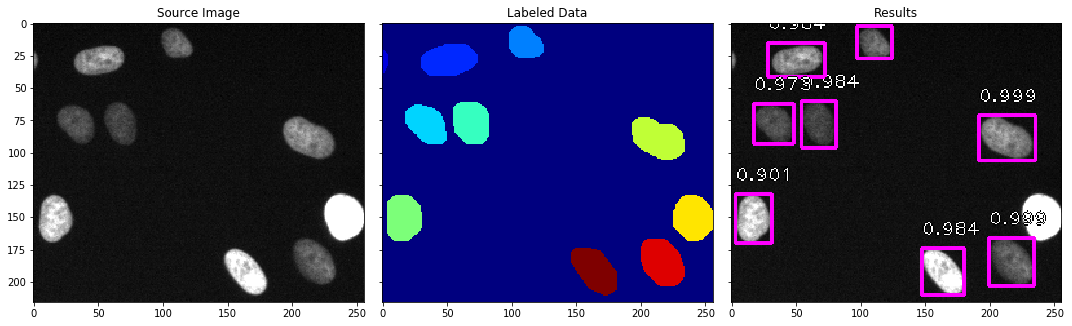

In [17]:
import matplotlib.pyplot as plt
import os
import time

import numpy as np

# from keras_maskrcnn.utils.visualization import draw_mask
from keras_retinanet.utils.colors import label_color
from keras_retinanet.utils.visualization import draw_box, draw_caption


index = np.random.randint(low=0, high=X_test.shape[0])
print('Image Number:', index)
image, mask = X_test[index:index + 1], y_test[index:index + 1]

start = time.time()
boxes, scores, labels = prediction_model.predict(image)
# boxes, scores, labels, masks = prediction_model.predict(image)
print('processing time: ', time.time() - start)

print('Minimum score:', scores.min())
print('Maximum score:', scores.max())

image = 0.01 * np.tile(np.expand_dims(image[0, ..., 0], axis=-1), (1, 1, 3))
mask = np.squeeze(mask)

# copy to draw on
draw = image.copy()

for box, score, label in zip(boxes[0], scores[0], labels[0]):
    if score < 0.5:
        break

    color = label_color(label)

    b = box.astype(int)
    draw_box(draw, b, color=color)

#     mask = mask[:, :, label]
#     draw_mask(draw, b, mask, color=label_color(label))

    caption = "{:.3f}".format(score)
    draw_caption(draw, b, caption)

fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(15, 15), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(image, cmap='jet')
ax[0].set_title('Source Image')

ax[1].imshow(mask, cmap='jet')
ax[1].set_title('Labeled Data')

ax[2].imshow(draw, cmap='jet')
ax[2].set_title('Results')

fig.tight_layout()
plt.show()